# COGS 108 - Final Project 

## Permissions

Place an `X` in the appropriate bracket below to specify if you would like your group's project to be made available to the public. (Note that PIDs will be scraped from the public submission, but student names will be included.)

* [  ] YES - make available
* [ x ] NO - keep private

# Overview

*Fill in your overview here*

# Names

- Yang Li
- Yiou Lyu
- Linfeng Hu
- Ruby Celeste Marroquin 

# Group Members IDs

- A15560579
- A15930345
- A15473121
- A16094382

# Research Question

How does the regional economic status of each province in mainland China correlate to its breakout and recovery of COVID-19?

## Background and Prior Work

*Fill in your background and prior work here* 

References (include links):
- 1)
- 2)

# Hypothesis


*Fill in your hypotheses here*

# Dataset(s)

(Copy this information for each dataset)
- Dataset Name: 
- Link to the dataset:
- Number of observations:

1-2 sentences describing each dataset. 

If you plan to use multiple datasets, add 1-2 sentences about how you plan to combine these datasets.

# Setup

In [1]:
import pandas as pd
import json
import codecs
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import os
import patsy
import scipy.stats as stats

import bs4
from bs4 import BeautifulSoup


# Data Cleaning

In [2]:
#with codecs.open('Data/virus.json', 'r', 'utf-8') as data_file:
    #data_teacher = json.load(data_file, 'utf-8')

#topic[worksheet] = data_teacher[worksheetID]['Topic']
#out = codecs.open('Worksheet.csv', 'w', 'utf-8')
#out.write(topic[worksheet])

To clean our data, our general approach is to represent datasets in pandas dataframe. Then we drop irrelevant information or outliers in data. We also rename the columns to make it easier for later analyses.

Firstly, we deal with the datasets that consist of economic status data. 

This is the income per capita value for each province in mainland China. Income is measured in yuan. 

In [3]:
Income = pd.read_csv('Data/Income.csv')
Income = Income.dropna(axis=1, how='all')
#Income.head()

This is the per capita Gross Regional Product value for each province. GRP per capita is measured in yuan.

In [4]:
GRP = pd.read_csv('Data/GRP.csv')
GRP = GRP.dropna(axis=1, how='all')
#GRP.head()

Next, we move on to clean the population density related datasets.

Population per province here is calculated in the unit of 10000 persons). It includes all residents (permanent and temporary, rural and urban)at the end of that year.

In [5]:
population = pd.read_csv('Data/Population.csv')
population = population.dropna(axis = 1, how = 'all')
#population.head()

To calculate population density of a region, we also need to areas of each province. Here, area of each province is measured in unit of square kilometers.

Since we only need the area information of each separate region, we will drop the "Toal" row at the end which contains information about the total area of China(judging by the data contained, the row name should be a typo). We will also drop the proportion row because we only need the area number. 

In [6]:
area = pd.read_csv('Data/Area.csv')
area = area.dropna(axis = 1, how = 'all')
#shorten column names to make following analysis simpler
area = area.rename(columns={"Area (sq.km)": "Area"})
area = area[area.District != 'Toal']
area = area[area.columns[:2]]
area = area.rename(columns = {'District':'Region'})
area.head()

,Region,Area
0,Shanghai,8359
1,Tianjin,"11,917"
2,Beijing,"16,406"
3,Hainan,"35,177"
4,Ningxia,"51,893"


we also need to remove "," in the string in order to change it to type int.

In [7]:
def remove_comma(strin):
    strin = strin.replace(',','')
    return strin

area['Area']= area['Area'].apply(remove_comma)
area.head()

,Region,Area
0,Shanghai,8359
1,Tianjin,11917
2,Beijing,16406
3,Hainan,35177
4,Ningxia,51893


## Read Virus Data

In [8]:
# read virus data into dataframes 
list_of_virus_data = list()

# append data between Feb 1 and Feb 25 to list
for i in range(20200201,20200226): 
    path = './Data/virus/' + str(i) + '.csv'
    df = pd.read_csv(path)
    list_of_virus_data.append(df)
    
# File 20200226.csv is missing, reason unknow. 

    
# append data between Feb 27 and Feb 29 to list
for i in range(20200227,20200230): 
    path = './Data/virus/' + str(i) + '.csv'
    df = pd.read_csv(path)
    list_of_virus_data.append(df)

# append data between Mar 1 and  Mar 1 to list
for i in range(20200301,20200302): 
    path = './Data/virus/' + str(i) + '.csv'
    list_of_virus_data.append(pd.read_csv(path))
# access ith elment in the list using list_of_virus_data[i]
# for example list_of_virus_data[0] gives the first dataframe

## Cleaning Virus Data

### Defind functions that will be used when cleaning virus daeta

In [9]:
# remove spaces from string
def remove_space(string):
    try:
        return string.replace(" ","")
    except:
        return np.nan
    
# Find the maximum numerical number in a row
def find_max_in_a_row(df,row_index):
    num_cols = df.shape[1]
    max = 0
    for i in range(0,num_cols):
        value_in_ith_col = df.iloc[row_index,i]
        try:
            value_in_ith_col = remove_space(value_in_ith_col)
            if (int(value_in_ith_col) > max):
                max = int(value_in_ith_col)
        except:
            pass
    return max

# Find the maximum numerical numbers in each row of the dataframe, save them into df['max']
def find_max_in_a_dataframe(df):
    df['max'] = np.nan
    for i in range(0,df.shape[0]):
        df.loc[i,'max'] = find_max_in_a_row(df,i)
        
# Find the string in the data frame
# Return row_index,col_index of the string if the string is found
def find_string(df,string_to_find):
    num_rows = df.shape[0]
    num_cols = df.shape[1]
    for row_index in range(0,num_rows):
        for col_index in range(0,num_cols):
            if (df.iloc[row_index,col_index] == string_to_find):
                return row_index,col_index
    raise Exception("string_to_find not found") 
    return


# Find "Hubei" in df
# Return row_index,col_index of "Hubei" if "Hubei" is found
def find_Hubei(df):
    return find_string(df,"Hubei")

def drop_population_column(df):
    
# drop column that contains '(10,000s)'
    try:
        target_string_3 = '(10,000s)'
        target_string_3_col_index = find_string(df,target_string_3)[1]
        df = df.drop(df.columns[target_string_3_col_index],axis=1)
    except:
        pass
# drop column that contains "Population (in 10,000s)"    
    try:
        target_string_1 = "Population (in 10,000s)"
        target_string_1_col_index = find_string(df,target_string_1)[1]
        df = df.drop(df.columns[target_string_1_col_index],axis=1)
    except:
        pass
# drop column that contains "Population"
    try:
        target_string_2 = "Population"
        target_string_2_col_index = find_string(df,target_string_2)[1]
        df =df.drop(df.columns[target_string_2_col_index],axis=1)
    except:
        return df
    
# index of "Province/Region/City" = col_index of Hubei
# "Confirmed Cases" = max value in every row


def clean_df_first_pass(df):
    # find column index of "Province/Region/City"
    city_col_index = find_Hubei(df)[1]
    df["Province/Region/City"] = df.iloc[:,city_col_index]
    find_max_in_a_dataframe(df)
    # Drop all rows above Hubei
    for i in range(0, find_Hubei(df)[0]):
        df = df.drop(i)
    # Find out df["Confirmed Cases"]
    df["Confirmed Cases"] = df['max']
    df = df[["Province/Region/City","Confirmed Cases"]]
    return df



def drop_rows_whose_city_length_too_long(df,max_length):
    num_rows = df.shape[0]
    for i in range(0,num_rows):
        try:
            city = df.loc[i,'Province/Region/City']
            city_length = len(city)
            if city_length > max_length:
                df = df.drop(i)
        except:
            if not(np.isnan(city)):
                raise Exception("fail to drop the " + str(i) + "th row, which is too long")
    return df

def get_city_cases(df,region_name):
    num_rows = df.shape[0]
    return (df[df["Province/Region/City"] == region_name]["Confirmed Cases"]).iloc[0]



def merge_one_day(day:int):
    day_name = "Day " + str(day)
    df[day_name] = np.nan
    for i in range(0,df.shape[0]):
        #print(i)
        try:
            region_name = df.loc[i,"Province/Region/City"]
            num_cases = get_city_cases(list_of_virus_data[day],region_name)
            df.loc[i,day_name] = num_cases
        except:
            df.loc[i,day_name] = np.nan

### Drop population column from all virus dataframes

In [10]:
for i in range (0,len(list_of_virus_data)):
    try:
        list_of_virus_data[i] = drop_population_column(list_of_virus_data[i])
    except:
        pass

### Clean df: First Pass

In [11]:
for i in range(0,len(list_of_virus_data)):
    try:
        list_of_virus_data[i] = clean_df_first_pass(list_of_virus_data[i])
    except:
        print(i)

### Gather all the province/area names from all dfs

In [12]:
# get all the province names
df = list_of_virus_data[0]
for i in range (1,len(list_of_virus_data)):
    df = df.merge(list_of_virus_data[i],on="Province/Region/City",how='outer')
df = df[["Province/Region/City"]]

### Drop rows whose city name is too long or too short (because these rows are not data for cities)

In [13]:

# Drop rows whose city names are too long
df = drop_rows_whose_city_length_too_long(df,25)


In [14]:
# merge all confirmed cases into df
for i in range(0,len(list_of_virus_data)):
    merge_one_day(i)

In [15]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

### Fill nan in df with 0

In [16]:
# Fill nan in df with 0
df = df.fillna(0)

### Merge all the dfs in list_of_virus_data into one df. Rows are province/area names, columns are the number of confirmed cases every day of the province/area names

In [17]:
# add one column in df, storing the ith day's day of each province
# df.insert(loc=len(df.columns),column="day 0",value=np.nan)
df["day0"] = np.nan
for i in range(0,df.shape[0]):
    region_name = df.loc[i,"Province/Region/City"]
    try:
        num_cases = get_city_cases(list_of_virus_data[0],region_name)
        df.loc[i,'day0'] = num_cases
    except:
        df.loc[i,'day0'] = np.nan

### Drop rows whose province/city/regison is 0 (nan)

In [18]:
for i in range(0,df.shape[0]):
    if (df.loc[i,'Province/Region/City'] == 0):
        df = df.drop(i)       

In [19]:
df

,Province/Region/City,Day 0,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Day 8,Day 9,Day 10,Day 11,Day 12,Day 13,Day 14,Day 15,Day 16,Day 17,Day 18,Day 19,Day 20,Day 21,Day 22,Day 23,Day 24,Day 25,Day 26,Day 27,Day 28,day0
0,Hubei,7153.0,9074.0,11177.0,13522.0,16678.0,19665.0,22112.0,24953.0,27100.0,29631.0,31728.0,33366.0,34874.0,51986.0,54406.0,56249.0,58182.0,59989.0,61682.0,62031.0,62662.0,63454.0,64084.0,64287.0,64786.0,65596.0,65914.0,66337.0,66907.0,7153.0
1,Zhejiang,599.0,661.0,724.0,829.0,895.0,954.0,1006.0,1048.0,1075.0,1104.0,1117.0,1131.0,1145.0,1155.0,1162.0,1167.0,1171.0,1172.0,1173.0,1175.0,1203.0,1205.0,1205.0,1205.0,1205.0,1205.0,1205.0,1205.0,1205.0,599.0
2,Guangdong,520.0,604.0,683.0,797.0,870.0,944.0,1018.0,1075.0,1120.0,1151.0,1177.0,1219.0,1241.0,1261.0,1294.0,1316.0,1322.0,1328.0,1331.0,1332.0,1333.0,1339.0,1342.0,1345.0,1347.0,1347.0,1348.0,1349.0,1349.0,520.0
3,Henan,422.0,493.0,566.0,675.0,764.0,851.0,914.0,981.0,1033.0,1073.0,1105.0,1135.0,1169.0,1184.0,1212.0,1231.0,1246.0,1257.0,1262.0,1265.0,1267.0,1270.0,1271.0,1271.0,1271.0,1272.0,1272.0,1272.0,1272.0,422.0
4,Hunan,389.0,463.0,521.0,593.0,661.0,711.0,772.0,803.0,838.0,879.0,912.0,946.0,968.0,988.0,1001.0,1004.0,1006.0,1007.0,1008.0,1010.0,1011.0,1013.0,1016.0,1016.0,1016.0,1017.0,1017.0,1018.0,1018.0,389.0
5,Anhui,297.0,340.0,408.0,480.0,530.0,591.0,665.0,733.0,779.0,830.0,860.0,889.0,910.0,934.0,950.0,962.0,973.0,982.0,986.0,987.0,988.0,989.0,989.0,989.0,989.0,989.0,990.0,990.0,990.0,297.0
6,Jiangxi,286.0,333.0,391.0,476.0,548.0,600.0,661.0,698.0,740.0,771.0,804.0,844.0,872.0,900.0,913.0,925.0,930.0,933.0,934.0,934.0,934.0,934.0,934.0,934.0,934.0,934.0,935.0,935.0,935.0,286.0
7,Chongqing,238.0,262.0,300.0,337.0,366.0,389.0,411.0,426.0,446.0,468.0,486.0,505.0,518.0,529.0,537.0,544.0,551.0,553.0,555.0,560.0,567.0,572.0,573.0,575.0,576.0,576.0,576.0,576.0,576.0,238.0
8,Sichuan,207.0,236.0,254.0,282.0,301.0,321.0,344.0,363.0,386.0,405.0,417.0,436.0,451.0,463.0,470.0,481.0,495.0,508.0,514.0,520.0,525.0,526.0,526.0,527.0,529.0,534.0,538.0,538.0,538.0,207.0
9,Jiangsu,202.0,231.0,271.0,308.0,341.0,373.0,408.0,439.0,468.0,492.0,515.0,543.0,570.0,593.0,604.0,617.0,626.0,629.0,631.0,631.0,631.0,631.0,631.0,631.0,631.0,631.0,631.0,631.0,631.0,202.0


# Data Analysis & Results

Correlation between Population density and economic status
This part is to analyze the correlation between population density and economic status. We found the data for both population and area by each province. It needs to be calculated to population density first by dividing population by area.

We decide to use the population data from the most recent year available, which is 2018.
We also need to change the column name to "district" to correspond with the area dataset.

In [20]:
population_2018 = population[population.columns[:2]]
population_2018.head()

,Region,2018
0,Beijing,2154
1,Tianjin,1560
2,Hebei,7556
3,Shanxi,3718
4,Inner Mongolia,2534


we will now merge the population and area dataset by the province name. We choose to "inner" merge them because if there is a province with either no population or area, we are unable to calculate the population density.
Then we could have calculate the population density by dividing population by area.
The unit for population density is number of people per square kilometer.

In [21]:
popu_density = pd.merge(population_2018,area,on = 'Region')
popu_density['Area'] = pd.to_numeric(popu_density['Area'])
popu_density['2018'] = pd.to_numeric(popu_density['2018'])
popu_density['population density'] = popu_density['2018']/popu_density['Area']
popu_density = popu_density.drop(columns = 'Area')
popu_density = popu_density.drop(columns = '2018')
popu_density.head()


,Region,population density
0,Beijing,0.131293
1,Tianjin,0.130905
2,Hebei,0.040075
3,Shanxi,0.023727
4,Shanxi,0.018082


we will now merge the data for population density and economic status by province. Since we use the population data in 2018 for calculating the population density, we will also use GRP in 2018 to find the correlation between population density and economic status.

In [22]:
co_pd_es = pd.merge(popu_density,GRP, on = 'Region')
co_pd_es = co_pd_es[co_pd_es.columns[:3]]
co_pd_es = co_pd_es.rename(columns = {'2018':'GRP'})
co_pd_es.head()

,Region,population density,GRP
0,Beijing,0.131293,140211
1,Tianjin,0.130905,120711
2,Hebei,0.040075,47772
3,Shanxi,0.023727,45328
4,Shanxi,0.018082,45328


Now we can look into the correlation between population density and GRP. we will make a scatter plot of GRP vs. population density and draw the linear regression line to show the relationship.

In [23]:
a1 = np.polyfit(co_pd_es['population density'],co_pd_es['GRP'],deg = 1)[0]
b1 = np.polyfit(co_pd_es['population density'],co_pd_es['GRP'],deg = 1)[1]
a1,b1

(418533.9004044728, 46606.9870364815)

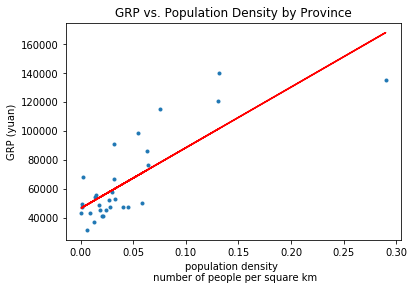

In [24]:
plt.plot(co_pd_es['population density'],co_pd_es['GRP'],'.')
plt.title('GRP vs. Population Density by Province')
plt.xlabel("population density \n number of people per square km" )
plt.ylabel("GRP (yuan)")
pred_GRP = co_pd_es['population density']*a1+b1
plt.plot(co_pd_es['population density'],pred_GRP,'red')

From this plot, it is clear that there is a positive relationship between population density and GRP. The regions with higher population density tend to have higher GRP. Thus, population density might also serve as a factor that confounds with the economic status. 

With better GRP, the province are expected to have a slower breakout rate due to the the better infrastructures like hospitals or clinics to support the citizens against the cirus. However, the breakout rates are actually tend to be higher with province with higher GRP. Population density might be the most important cofounding factor for this controversy. 

Now, we will look at the correlation between population density and the virus breakout rate to see whether they are in fact correlated.

# Ethics & Privacy

*Fill in your ethics & privacy discussion here*

# Conclusion & Discussion

*Fill in your discussion information here*

# Team Contributions

*Specify who in your group worked on which parts of the project.*